In [4]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import random
import os
import pandas as pd
import joblib
from sklearn.decomposition import PCA
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from PIL import Image
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from google.colab import files

TRAIN_TRANSFORM = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0))
])
TEST_TRANSFORM = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0))
])
BATCH_SIZE = 32
CLASSES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
EPOCHS = 5

In [5]:
# Load CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=TRAIN_TRANSFORM)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=TEST_TRANSFORM)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
X = np.array(train_dataset.data)
y = np.array(train_dataset.targets)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (40000, 32, 32, 3)
y_train shape: (40000,)
X_val shape: (10000, 32, 32, 3)
y_val shape: (10000,)


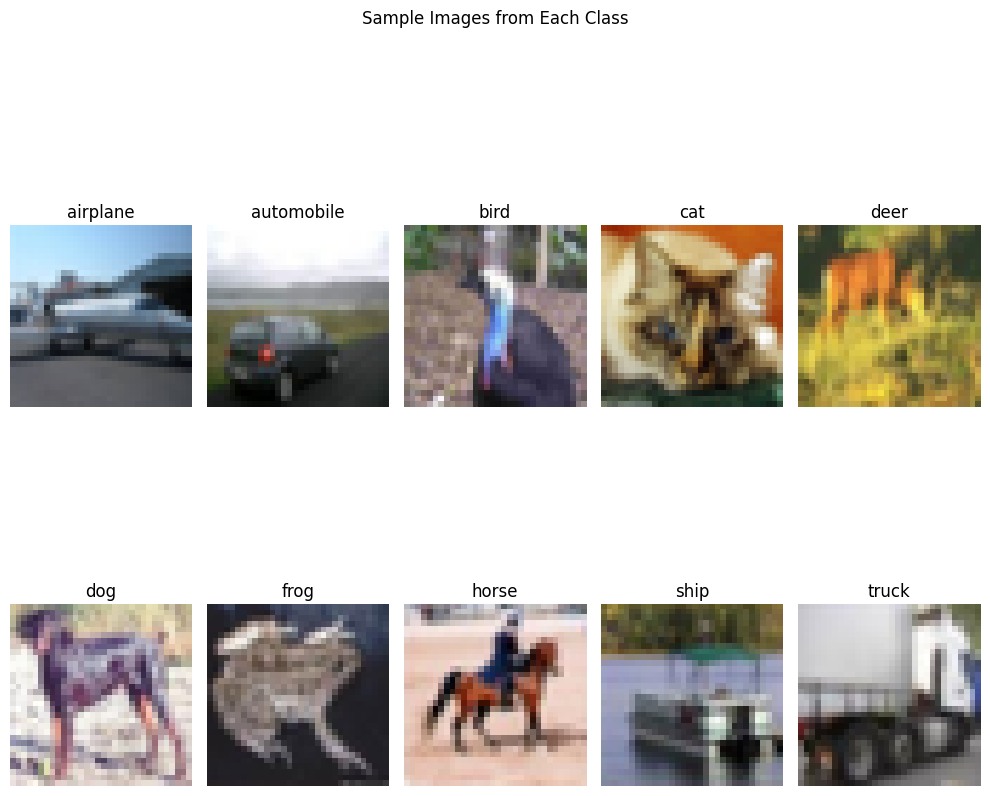

In [7]:
plt.figure(figsize=(10, 10))
for i in range(len(CLASSES)):
    # Find the index of the first image in the current class
    for j in range(len(y_train)):
        if y_train[j] == i:
            idx = j
            break

    # Get the first image in the current class
    image = X_train[idx]

    # Plot the image
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(image)
    plt.title(CLASSES[i])
    plt.axis('off')

plt.suptitle('Sample Images from Each Class')
plt.tight_layout()
plt.show()

In [8]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

print(f"X_train shape: {X_train_flat.shape}")
print(f"X_val shape: {X_val_flat.shape}")

X_train shape: (40000, 3072)
X_val shape: (10000, 3072)


In [9]:
X_test = np.array(test_dataset.data)
y_test = np.array(test_dataset.targets)

X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"X_test shape: {X_test_flat.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (10000, 3072)
y_test shape: (10000,)


In [10]:
def save_model(model):
    joblib.dump(model, f'{model.__class__.__name__}.pkl')
    print("Model saved!\n")

    files.download(f'{model.__class__.__name__}.pkl')

def load_model(model_name):
    model = joblib.load(f'{model_name}.pkl')
    print("Model loaded!\n")

    return model

In [9]:
log_reg_pipeline = make_pipeline(
    PCA(n_components=0.95, svd_solver='full', whiten=True, random_state=42),
    OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42))
)

param_grid = {
    'onevsrestclassifier__estimator__C': [0.1, 1, 10, 100],
    'onevsrestclassifier__estimator__penalty': ['l1', 'l2'],
    'onevsrestclassifier__estimator__solver': ['liblinear', 'saga']
}

model = GridSearchCV(log_reg_pipeline, param_grid, cv=5, scoring=['accuracy', 'f1_macro'], refit='accuracy', verbose=2)

In [ ]:
model.fit(X_train_flat, y_train)

print("Best parameters:", model.best_params_)

In [ ]:
print(f'Best score: {model.best_score_*100:.2f}%\n')

In [ ]:
save_model(model.best_estimator_)

Model saved!



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
!pip install scikit-learn-intelex

In [12]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [13]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import RBFSampler

svm_pipeline = make_pipeline(
    PCA(n_components=0.95, svd_solver='full', whiten=True, random_state=42),
    RBFSampler(gamma=0.1, random_state=42),
    OneVsRestClassifier(SVC(kernel='linear', random_state=42))
)

param_grid = {
    'onevsrestclassifier__estimator__C': [0.1, 1, 10, 100],
    'onevsrestclassifier__estimator__gamma': [0.01, 0.1, 'scale', 'auto'],
}

from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

model = GridSearchCV(
    svm_pipeline,
    param_grid,
    cv=sss,
    scoring=['accuracy', 'f1_macro'],
    refit='accuracy',
    verbose=2,
    n_jobs=-1
)

In [ ]:
model.fit(X_train_flat, y_train)

print("Best parameters:", model.best_params_)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline

svm_pipeline = make_pipeline(
    PCA(n_components=0.95, svd_solver='full', whiten=True, random_state=42),
    OneVsRestClassifier(SVC(kernel='rbf', random_state=42))
)

svm_pipeline.fit(X_train_flat, y_train)


In [ ]:
model = joblib.load('log_reg_model.pkl')


In [ ]:
def test(model, images, labels, val=False):
    pred = model.predict(images)
    acc = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average='macro')

    if val:
        print(f'Validation accuracy: {acc*100:.2f}% | Validation F1 score: {f1*100:.2f}%')
    else:
        print(f'Test Accuracy: {acc*100:.2f}% | Test F1 score: {f1*100:.2f}%')

In [ ]:
test(model, X_val_flat, y_val, val=True)

Validation accuracy: 40.68% | Validation F1 score: 40.15%


In [ ]:
test(model, X_test_flat, y_test, val=False)

Test Accuracy: 40.64% | Test F1 score: 40.08%


In [ ]:
-- ROBA VECCHIA --

In [ ]:
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q tiny-imagenet-200.zip && ls tiny-imagenet-200
!rm -rf tiny-imagenet-200.zip

--2025-01-22 09:34:42--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.64.64
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cs231n.stanford.edu/tiny-imagenet-200.zip [following]
--2025-01-22 09:34:42--  https://cs231n.stanford.edu/tiny-imagenet-200.zip
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  12.9MB/s    in 16s     

2025-01-22 09:34:59 (14.6 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]

test  train  val  wnids.txt  words.txt


In [ ]:
DATA_DIR = 'tiny-imagenet-200'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')

val_data = pd.read_csv(f'{VAL_DIR}/val_annotations.txt',
                       sep='\t',
                       header=None,
                       names=['File', 'Class', 'X', 'Y', 'H', 'W'])

val_data.head()

,File,Class,X,Y,H,W
0,val_0.JPEG,n03444034,0,32,44,62
1,val_1.JPEG,n04067472,52,55,57,59
2,val_2.JPEG,n04070727,4,0,60,55
3,val_3.JPEG,n02808440,3,3,63,63
4,val_4.JPEG,n02808440,9,27,63,48


In [ ]:
val_img_dir = os.path.join(VAL_DIR, 'images')

fp = open(os.path.join(VAL_DIR, 'val_annotations.txt'), 'r')
data = fp.readlines()

val_img_dict = {}
for line in data:
  words = line.split('\t')
  val_img_dict[words[0]] = words[1]
fp.close()

{k: val_img_dict[k] for k in list(val_img_dict)[:10]}

{'val_0.JPEG': 'n03444034',
 'val_1.JPEG': 'n04067472',
 'val_2.JPEG': 'n04070727',
 'val_3.JPEG': 'n02808440',
 'val_4.JPEG': 'n02808440',
 'val_5.JPEG': 'n04399382',
 'val_6.JPEG': 'n04179913',
 'val_7.JPEG': 'n02823428',
 'val_8.JPEG': 'n04146614',
 'val_9.JPEG': 'n02226429'}

In [ ]:
for img, folder in val_img_dict.items():
  new_path = (os.path.join(val_img_dir, folder))
  if not os.path.exists(new_path):
    os.makedirs(new_path)
  if os.path.exists(os.path.join(val_img_dir, img)):
    os.rename(os.path.join(val_img_dir, img), os.path.join(new_path, img))

In [ ]:
class_to_name_dict = dict()
fp = open(os.path.join(DATA_DIR, 'words.txt'), 'r')
data = fp.readlines()
for line in data:
  words = line.strip('\n').split('\t')
  class_to_name_dict[words[0]] = words[1].split(',')[0]
fp.close()

{k: class_to_name_dict[k] for k in list(class_to_name_dict)[:20]}

{'n00001740': 'entity',
 'n00001930': 'physical entity',
 'n00002137': 'abstraction',
 'n00002452': 'thing',
 'n00002684': 'object',
 'n00003553': 'whole',
 'n00003993': 'congener',
 'n00004258': 'living thing',
 'n00004475': 'organism',
 'n00005787': 'benthos',
 'n00005930': 'dwarf',
 'n00006024': 'heterotroph',
 'n00006150': 'parent',
 'n00006269': 'life',
 'n00006400': 'biont',
 'n00006484': 'cell',
 'n00007347': 'causal agent',
 'n00007846': 'person',
 'n00015388': 'animal',
 'n00017222': 'plant'}

In [ ]:
class TinyImageNet(Dataset):
    _TRAIN_DIR = TRAIN_DIR
    _VAL_DIR = val_img_dir

    def __init__(self, split='train', transform=None):
        super().__init__()
        self.transform = transform

        if split == 'train':
            dataset = torchvision.datasets.ImageFolder(root=self._TRAIN_DIR, transform=transforms.ToTensor())
        elif split == 'val':
            dataset = torchvision.datasets.ImageFolder(root=self._VAL_DIR, transform=transforms.ToTensor())

        self.imgs_path = np.array(dataset.imgs)
        self.labels = np.array(dataset.targets)

    def __len__(self):
        return len(self.imgs_path)

    def __getitem__(self, idx):
        img_path, label = self.imgs_path[idx]
        img = Image.open(img_path)

        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [ ]:
def normalize_and_flatten(images):
    flattened_images = []

    for i in range(len(images)):
        image = images[i]
        image = image.permute(1, 2, 0)  # Permute to (H, W, C)
        flattened_images.append(image.numpy().flatten())

    return np.array(flattened_images)

In [ ]:
TRANSFORM = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor()
])

train_dataset = TinyImageNet(split='train', transform=TRANSFORM)
val_dataset = TinyImageNet(split='val', transform=TRANSFORM)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
flattened_train_images = normalize_and_flatten(train_dataset)

svm_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=0.95),
    OneVsRestClassifier(SVC(kernel='linear', C=0.1, class_weight='balanced'))
)

svm_pipeline.fit(flattened_train_images, train_dataset.labels)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}
grid = GridSearchCV(svm_pipeline, param_grid, cv=5, scoring='accuracy', verbose=2)
grid.fit(flattened_train_images, train_dataset.labels)

print("Best parameters:", grid.best_params_)

In [ ]:
EPOCHS = 1
K_FOLD = 5

def training(model, train_loader, scaler, pca, scores=None):
    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}:")

        for batch, (images, labels) in tqdm(enumerate(train_loader), unit='batch', total=len(train_loader)):
            flattened_images = normalize_and_flatten(images)
            scaled_images = scaler.fit_transform(flattened_images)
            pca_images = pca.fit_transform(scaled_images)

            labels = np.asarray(labels)

            model.fit(pca_images, labels)

def validation(model, val_loader, scaler, pca):
    val_acc = 0.0

    for batch, (images, labels) in enumerate(val_loader):
        flattened_images = images.reshape(images.shape[0], -1) / 255.0
        scaled_images = scaler.transform(flattened_images)
        pca_images = pca.transform(scaled_images)

        labels = np.asarray(labels)

        pred = model.predict(pca_images)
        val_acc += accuracy_score(labels, pred)

    val_acc /= len(val_loader)
    print(f"Val acc: {val_acc * 100:.2f}%\n")

    return val_acc

def testing(model, test_loader, scaler, pca):
    results = {'pred':[], 'labels':[]}
    test_acc = 0.0
    test_f1 = 0.0

    print("Testing...")
    for batch, (images, labels) in tqdm(enumerate(test_loader), unit='batch', total=len(test_loader)):
        flattened_images = normalize_and_flatten(images)
        scaled_images = scaler.transform(flattened_images)
        pca_images = pca.transform(scaled_images)

        labels = np.asarray(labels)

        pred = model.predict(pca_images)

        results['pred'].extend(pred)
        results['labels'].extend(labels)
        test_acc += accuracy_score(labels, pred)
        test_f1 += f1_score(labels, pred, average='macro')

    test_acc /= len(test_loader)
    test_f1 /= len(test_loader)
    print(f"Test acc: {test_acc * 100:.2f}% | Test f1: {test_f1 * 100:.2f}%\n")

    return results

def k_fold_cross_validation(k_fold, train_dataset, scaler, pca, model_type, scores):
    best_acc = 0.0

    for fold, (train_idx, val_idx) in enumerate(k_fold.split(train_dataset)):
        print(f"####Fold {fold + 1}####\n")

        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

        train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_subsampler, num_workers=2)
        val_loader = DataLoader(train_dataset, batch_size=32, sampler=val_subsampler, num_workers=2)

        if model_type == 'svm':
            model = SVC(kernel='linear', C=0.1, class_weight='balanced')

        ovr = OneVsRestClassifier(model)

        training(ovr, train_loader, scaler, pca, scores)
        val_acc = validation(ovr, val_loader, scaler, pca)

        if val_acc > best_acc:
            best_acc = val_acc
            if model_type == 'svm':
                joblib.dump(ovr, 'svm_model.pkl')
                print("Model saved!\n")

    # acc_sum = 0
    # f1_sum = 0
    # for i in range(len(scores['train_acc'])):
    #     acc_sum += sum(scores['train_acc'][i])
    #     f1_sum += sum(scores['train_f1'][i])

    # mean_train_acc = acc_sum / (len(scores['train_acc']) * K_FOLD)
    # mean_train_f1 = f1_sum / (len(scores['train_f1']) * K_FOLD)
    # print(f"Mean train acc: {mean_train_acc * 100:.2f}% | Mean train F1 score: {mean_train_f1 * 100:.2f}%\n")

In [ ]:
import json
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, max_depth=30, random_state=42, n_jobs=-1)
scaler = StandardScaler()
pca = PCA(n_components=0.98)

training(model, train_loader, scaler, pca)
results = testing(model, test_val_loader, scaler, pca)

with open('svm_results.json', 'w') as f:
    json.dump(results, f)

Epoch 1:


  0%|          | 0/3125 [00:00<?, ?batch/s]

Testing...


  0%|          | 0/313 [00:00<?, ?batch/s]

Test acc: 0.60% | Test f1: 0.12%



In [ ]:
from sklearn.linear_model import LogisticRegression

model = OneVsRestClassifier(LogisticRegression(max_iter=1000))
scaler = StandardScaler()
pca = PCA(n_components=0.95)

training(model, train_loader, scaler, pca)
testing(model, test_val_loader, scaler, pca)

Epoch 1:


  0%|          | 0/3125 [00:00<?, ?batch/s]

Testing...


  0%|          | 0/313 [00:00<?, ?batch/s]

Test acc: 0.30% | Test f1: 0.09%



In [ ]:
print(f'### CROSS VALIDATION ON SVM ###\n')
k_fold = KFold(n_splits=K_FOLD, shuffle=True, random_state=42)
scaler = StandardScaler()
pca = PCA(n_components=0.95)
scores = {'train_acc': [], 'train_f1': []}

k_fold_cross_validation(k_fold, train_dataset, scaler, pca, 'svm', scores)

print(f'#### TESTING ####\n')
model = joblib.load('svm_model.pkl')
testing(model, test_val_loader)

### CROSS VALIDATION ON SVM ###

####Fold 1####



  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1:


KeyboardInterrupt: 

In [ ]:
folds = ['Fold_1', 'Fold_2', 'Fold_3', 'Fold_4', 'Fold_5']
df = pd.DataFrame(scores, index=folds)
df.to_csv('svm_scores.csv')

In [ ]:
from google.colab import files

files.download('svm_model.pkl')
files.download('svm_scores.csv')